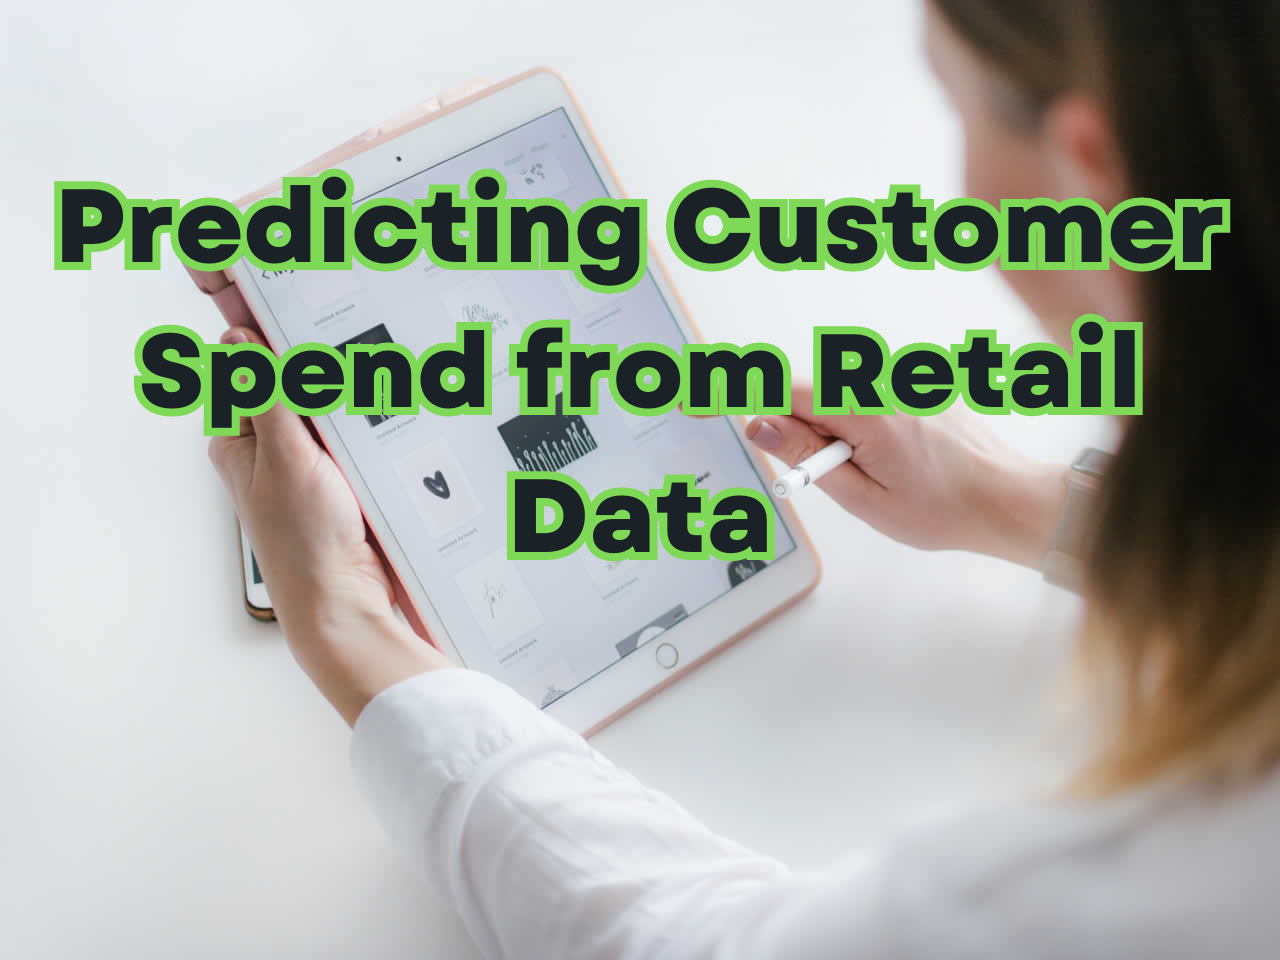

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
from IPython import display
import nbconvert
import joblib
display.Image("PCS.png")

-----------------------

### Importing Data Files

In [22]:
#Import Product DataSet here
product_data = pd.read_csv('Product Data Set.csv',sep='|')
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [23]:
#Import Transaction DataSet Here
transactions_data = pd.read_csv('Transaction Data Set.csv',sep='|')
transactions_data.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [24]:
#Import Customer Dataset Here
customer_data=pd.read_csv('Customer Data Set.csv')
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


-------------------------------------------

### Changing Data Types

In [25]:
# Clean data: remove '$' symbol from INCOME column and convert to integer
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

-----------------------------------------------------

### Creating Customer View

In [26]:
# Merge transaction and product datasets using 'PRODUCT NUM' and 'PRODUCT CODE' columns
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

# Calculate Total_Price for each transaction
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

# Group transactions by customer number and product category and calculate total spending per category
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})
customer_prod_categ=customer_prod_categ.reset_index()

# Pivot the table to create customer spending data for each product category
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

# Calculate total spending per customer
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

# Merge all the customer data together
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )
customer_KPIs=customer_KPIs.fillna(0)
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


------------------------

# Linear Regression 
### Feed the following variables to the linear regression model to predict the total spending of the customers.

In [27]:
DF_input=customer_all_view[['GENDER','AGE','INCOME','EXPERIENCE SCORE','LOYALTY GROUP','HOUSEHOLD SIZE','MARITAL STATUS']]
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS
0,0,64,133498,5,enrolled,4,Single
1,0,42,94475,9,notenrolled,6,Married
2,0,40,88610,9,enrolled,5,Married
3,0,38,84313,8,enrolled,1,Single
4,0,30,51498,3,notenrolled,1,Single


-------------------------

### Next we create four columns that are named Single, Married, Divorced, and Widow/Widower. We then use <code>pd.get_dummies</code> so that we can actually use this data in our regression model.

In [28]:
DF_input["MARITAL STATUS"].unique()
pd.get_dummies(DF_input["MARITAL STATUS"]).head(10)

,Divorced,Married,Single,Widow/Widower
0,False,False,True,False
1,False,True,False,False
2,False,True,False,False
3,False,False,True,False
4,False,False,True,False
5,False,True,False,False
6,False,True,False,False
7,False,False,True,False
8,False,True,False,False
9,False,True,False,False


--------------------------------

### We utlise a binary encoder function on the loyalty variable to get an idea if the customer is enrolled in the "rewards" programme and <code>apply</code> it to the "LOYALTY GROUP" column in the dataframe.

In [29]:
def encode_loyalty(value):
    if value == "enrolled" :
        return 1 
    else : 
        return 0

In [30]:
#Apply this function to the “loyalty group” column
DF_input['LOYALTY GROUP']=DF_input['LOYALTY GROUP'].apply(encode_loyalty)
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS
0,0,64,133498,5,1,4,Single
1,0,42,94475,9,0,6,Married
2,0,40,88610,9,1,5,Married
3,0,38,84313,8,1,1,Single
4,0,30,51498,3,0,1,Single


In [31]:
#replace the “DF_input” frame with the one-hot encoded Pandas data frame
DF_input=pd.get_dummies(DF_input)
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,0,64,133498,5,1,4,False,False,True,False
1,0,42,94475,9,0,6,False,True,False,False
2,0,40,88610,9,1,5,False,True,False,False
3,0,38,84313,8,1,1,False,False,True,False
4,0,30,51498,3,0,1,False,False,True,False


-------------------------------------

### We need to re-create the Pandas data frame for the NumPy format.

In [32]:
# Scale the input data using StandardScaler
DF_input_column_names = DF_input.columns.values
scaler = preprocessing.StandardScaler()
DF_input_np = scaler.fit_transform(DF_input)
Reg_input_scaled = pd.DataFrame(DF_input_np, columns=DF_input_column_names)
Reg_input_scaled.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,-0.996008,1.235560,1.285150,-0.622743,0.945484,0.693044,-0.28269,-1.070478,1.333333,-0.181818
1,-0.996008,-0.018006,0.233900,0.980199,-1.057660,1.946288,-0.28269,0.934162,-0.750000,-0.181818
2,-0.996008,-0.131966,0.075902,0.980199,0.945484,1.319666,-0.28269,0.934162,-0.750000,-0.181818
3,-0.996008,-0.245927,-0.039856,0.579463,0.945484,-1.186822,-0.28269,-1.070478,1.333333,-0.181818
4,-0.996008,-0.701769,-0.923867,-1.424213,-1.057660,-1.186822,-0.28269,-1.070478,1.333333,-0.181818


----------------------------

### We need to create a train-test split with the data from the <code>Reg_input_scaled</code> and start training the model on the training data set.

In [33]:
#Create a train – test split of 80% training and 20% testing
X_train,X_test,Y_train,Y_test = train_test_split(Reg_input_scaled,customer_all_view['TOTAL SPENT'], test_size=0.2,random_state=42)
#Train the model on the training data set
regr = LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

In [34]:
#predict the values of total spending for the testing feature.
Y_pred = regr.predict(X_test)
Y_pred

array([7157.285444  , 5243.63936015, 3987.6412211 , 5316.32194008,
       5428.51049731, 1196.18784911, 4453.66121268, 5193.93571476,
       2669.27128768, 2527.03970635, 3799.00987099, 6216.4223513 ,
       2311.15909854, 5090.92483534, 2911.02572576, 7891.38782929,
       8066.91378862, 4126.08001366, 2970.34015904, 5926.25815311,
       6744.90285684, 5372.96090939, 5936.11281731, 8542.03230131,
       5730.79351497, 4403.99572629, 7683.42694125, 2675.32648463,
       3226.3927283 , 5169.38293198, 7031.63388155, 2038.02977206,
       8074.49245041, 5699.61742214, 7100.38439531, 4054.83570725,
       4518.7627326 , 5796.13138509, 8272.92793   , 6240.77875451,
       8105.35222614, 8936.97710415, 1667.99693359, 8203.76449446,
       7443.41073744, 2001.6560831 , 8647.42469329, 5420.22003182,
       2931.46279203, 8333.66700834, 3192.41711188, 4701.05917022,
       4745.16983121, 8803.69221963, 5519.76357506, 1728.60795184,
       7586.43295134, 8568.0016388 , 5363.43222064, 5246.99435

In [35]:
#order of coefficients
Reg_input_scaled.columns.values

array(['GENDER', 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'LOYALTY GROUP',
       'HOUSEHOLD SIZE', 'MARITAL STATUS_Divorced',
       'MARITAL STATUS_Married', 'MARITAL STATUS_Single',
       'MARITAL STATUS_Widow/Widower'], dtype=object)

In [36]:
#Obtain the intercept and Coefficients.
print('intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

intercept: 
 5351.508964940447
Coefficients: 
 [   17.79233204 -1724.81228191  3548.63240025   140.25488355
   782.01137631   332.00213426   103.56912581   -31.78346223
    -7.80669623   -42.66603075]


----------------------------------

### Evaluate the performance of the linear model by calculating the mean (squared) error.

In [37]:
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred)) 

Mean squared error: 3164098.64


In [38]:
#Get the Mean Error
print('The Mean Error is = ', math.sqrt(mean_squared_error(Y_test, Y_pred)))
print("Which means that there is an error of : $", math.sqrt(mean_squared_error(Y_test, Y_pred)) )
joblib.dump(regr, 'linear_regression_model.pkl')

The Mean Error is =  1778.7913411697498
Which means that there is an error of : $ 1778.7913411697498


['linear_regression_model.pkl']

----------------------------------

### Put the model to the test

In [39]:
# Load the trained model
regr = joblib.load('linear_regression_model.pkl')

# Create a new DataFrame for a new customer
new_customer = pd.DataFrame({
    'GENDER': ['Male'],
    'AGE': [35],
    'INCOME': [100000],
    'EXPERIENCE SCORE': [8],
    'LOYALTY GROUP': ['enrolled'],
    'HOUSEHOLD SIZE': [2],
    'MARITAL STATUS': ['Married']
})

# Rename columns to match those used during training
new_customer = new_customer.rename(columns={'GENDER': 'GENDER_Male', 'LOYALTY GROUP': 'LOYALTY GROUP_enrolled', 'HOUSEHOLD SIZE': 'HOUSEHOLD SIZE_2', 'MARITAL STATUS': 'MARITAL STATUS_Married'})

# Add missing columns if necessary
new_customer['LOYALTY GROUP_not enrolled'] = 0
# new_customer['HOUSEHOLD SIZE_1'] = 0
# new_customer['HOUSEHOLD SIZE_3+'] = 0
new_customer['MARITAL STATUS_Single'] = 0
new_customer['MARITAL STATUS_Widow/Widower'] = 0

# One-hot encode the categorical variables
new_customer_encoded = pd.get_dummies(new_customer)

# Scale the input data using the same scaling as the training data
scaler = preprocessing.StandardScaler()
new_customer_scaled = scaler.fit_transform(new_customer_encoded)

# Make a prediction for the new customer's total spending
predicted_total_spending = regr.predict(new_customer_scaled)[0]

print("The predicted total spending for the new customer is: $", round(predicted_total_spending, 2))

The predicted total spending for the new customer is: $ 5351.51


------------------------------------------------------